# Predictive Maintenance - Regression Approach

> Task 1 - build a model to answer a question
question: Model the err, and errf columns for individual 'scanners' to show a expected failure rate of the encoder component. Scanners identified into two groups, based on the following criteria and grouping:

  never fail: scanners whom never reach the 12 % range for err
  routinely fail: scanners whom reach the 12% range for err on a routine basis

  err and errf are both float values, they are loosely tied to each other, and are not a 1 for 1 relationship, e.g. a rising err value doesn't mean a errf value will rise, nor the opposite. Failure is defined as a err that is above 12 % and/or a errf that is above 0.5 %


  background: err and errf represent a encoder error rate at which a led light is pulsating into a window barrier. This barrier, and subsequent calculation, represent the rate of rotation of a component, and the compensated ERRor and ERRor Filtered value.

>task 2 - explain why the model was chosen to answer the question asked

>task 3 - explain the performance of the model, and of other models that would prove the same question.

>task-5: Build documentation and share it across.

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-whitegrid')
from plotly import __version__


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import re

<ipython-input-5-68f83b440201>:9: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



In [ ]:
df = pd.read_csv("/content/encoders (1).csv", parse_dates=['date'], infer_datetime_format=True)

<ipython-input-6-0e122ee45a4a>:1: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [ ]:
df.head()

,id,date,scanner,min,max,err,pixels,minf,maxf,errf,created_at,updated_at
0,12,2017-12-17,K219,35435,35933,1.40,6,35681,35688,0.02,NaN,2017-12-29 16:26:16.475205
1,30,2017-12-18,H161,35155,36382,3.43,14,35731,35761,0.08,NaN,2017-12-29 16:26:16.872783
2,47,2017-12-18,K211,35305,36042,2.07,43,35692,35739,0.13,NaN,2017-12-19 18:10:57.453846
3,48,2017-12-18,K212,35216,36225,2.82,61,35686,35726,0.11,NaN,2017-12-19 18:10:57.45983
4,49,2017-12-18,K220,35196,36259,2.98,11,35709,35724,0.04,NaN,2017-12-19 18:10:57.464388


Note:
> From the "updates_at" value we can get the duration of which scanner worked before doing the measurement

In [ ]:
df = df.drop(['updated_at', 'date'], axis = 1)
df = df.loc[~((df['min']<=0) & (df['max']<=0) & (df['err']<=0)),:]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2603 entries, 0 to 2751
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2603 non-null   int64  
 1   scanner     2603 non-null   object 
 2   min         2603 non-null   int64  
 3   max         2603 non-null   int64  
 4   err         2603 non-null   float64
 5   pixels      2603 non-null   int64  
 6   minf        2603 non-null   int64  
 7   maxf        2603 non-null   int64  
 8   errf        2603 non-null   float64
 9   created_at  0 non-null      float64
dtypes: float64(3), int64(6), object(1)
memory usage: 223.7+ KB


In [ ]:
df.head()

,id,scanner,min,max,err,pixels,minf,maxf,errf,created_at
0,12,K219,35435,35933,1.40,6,35681,35688,0.02,NaN
1,30,H161,35155,36382,3.43,14,35731,35761,0.08,NaN
2,47,K211,35305,36042,2.07,43,35692,35739,0.13,NaN
3,48,K212,35216,36225,2.82,61,35686,35726,0.11,NaN
4,49,K220,35196,36259,2.98,11,35709,35724,0.04,NaN


We can see that zero non-null values in created_at so we can diretly delete or remove this column

In [ ]:
df = df.drop(['created_at'], axis=1)
print(df.head())

   id scanner    min    max   err  pixels   minf   maxf  errf
0  12    K219  35435  35933  1.40       6  35681  35688  0.02
1  30    H161  35155  36382  3.43      14  35731  35761  0.08
2  47    K211  35305  36042  2.07      43  35692  35739  0.13
3  48    K212  35216  36225  2.82      61  35686  35726  0.11
4  49    K220  35196  36259  2.98      11  35709  35724  0.04


In [ ]:
df.columns

Index(['id', 'scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf'], dtype='object')

In [ ]:
from numpy import absolute
df['MaxMinDiff'] = absolute(df['max']-df['min'])

df['MaxfMinfDiff'] = absolute(df['maxf']-df['minf'])

In [ ]:
df

,id,scanner,min,max,err,pixels,minf,maxf,errf,MaxMinDiff,MaxfMinfDiff
0,12,K219,35435,35933,1.40,6,35681,35688,0.02,498,7
1,30,H161,35155,36382,3.43,14,35731,35761,0.08,1227,30
2,47,K211,35305,36042,2.07,43,35692,35739,0.13,737,47
3,48,K212,35216,36225,2.82,61,35686,35726,0.11,1009,40
4,49,K220,35196,36259,2.98,11,35709,35724,0.04,1063,15
...,...,...,...,...,...,...,...,...,...,...,...
2745,2745,K168,35185,35958,2.17,48,35541,35565,0.07,773,24
2746,2747,K114,35220,36071,2.39,17,35715,35735,0.06,851,20
2747,2748,K171,35109,35912,2.26,50,35504,35531,0.08,803,27
2750,2751,K220,35181,36229,2.94,9,35702,35715,0.04,1048,13


<ipython-input-15-1b1b8ef642a5>:3: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

<ipython-input-15-1b1b8ef642a5>:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<Axes: xlabel='MaxfMinfDiff', ylabel='errf'>

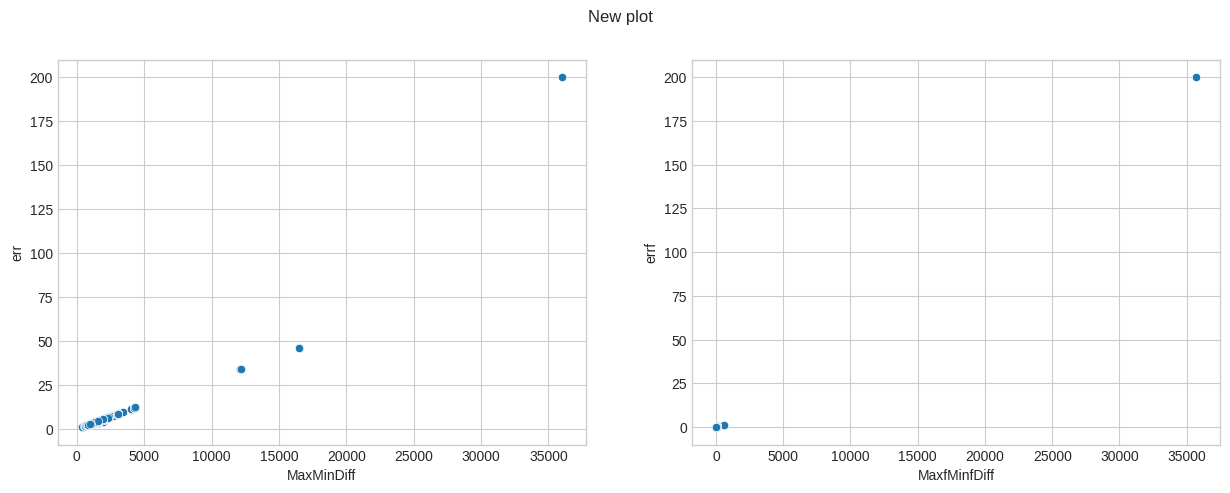

In [ ]:
f, axes = plt.subplots(1,2, figsize=(15, 5), facecolor='white')
f.suptitle('New plot')
sns.scatterplot(x=df['MaxMinDiff'],y=df['err'],palette ="Set1",ax=axes[0])
sns.scatterplot(x=df['MaxfMinfDiff'],y=df['errf'],palette ="Set1", ax=axes[1])

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df, x='MaxMinDiff', y='err', z='pixels', color='scanner')

fig.show()

In [ ]:
df_copy = df.drop('scanner',axis =1)
df_copy['Failure'] = np.where((df_copy['err'] >= 12.0) | (df_copy['errf'] >=0.5),2, 1)
df_copy['Failure'].unique()

array([1, 2])

In [ ]:
df_copy['Failure'].value_counts()


Failure
1    2591
2      12
Name: count, dtype: int64

In [ ]:
df_copy['scanner'] = df['scanner']

<Axes: xlabel='scanner', ylabel='count'>

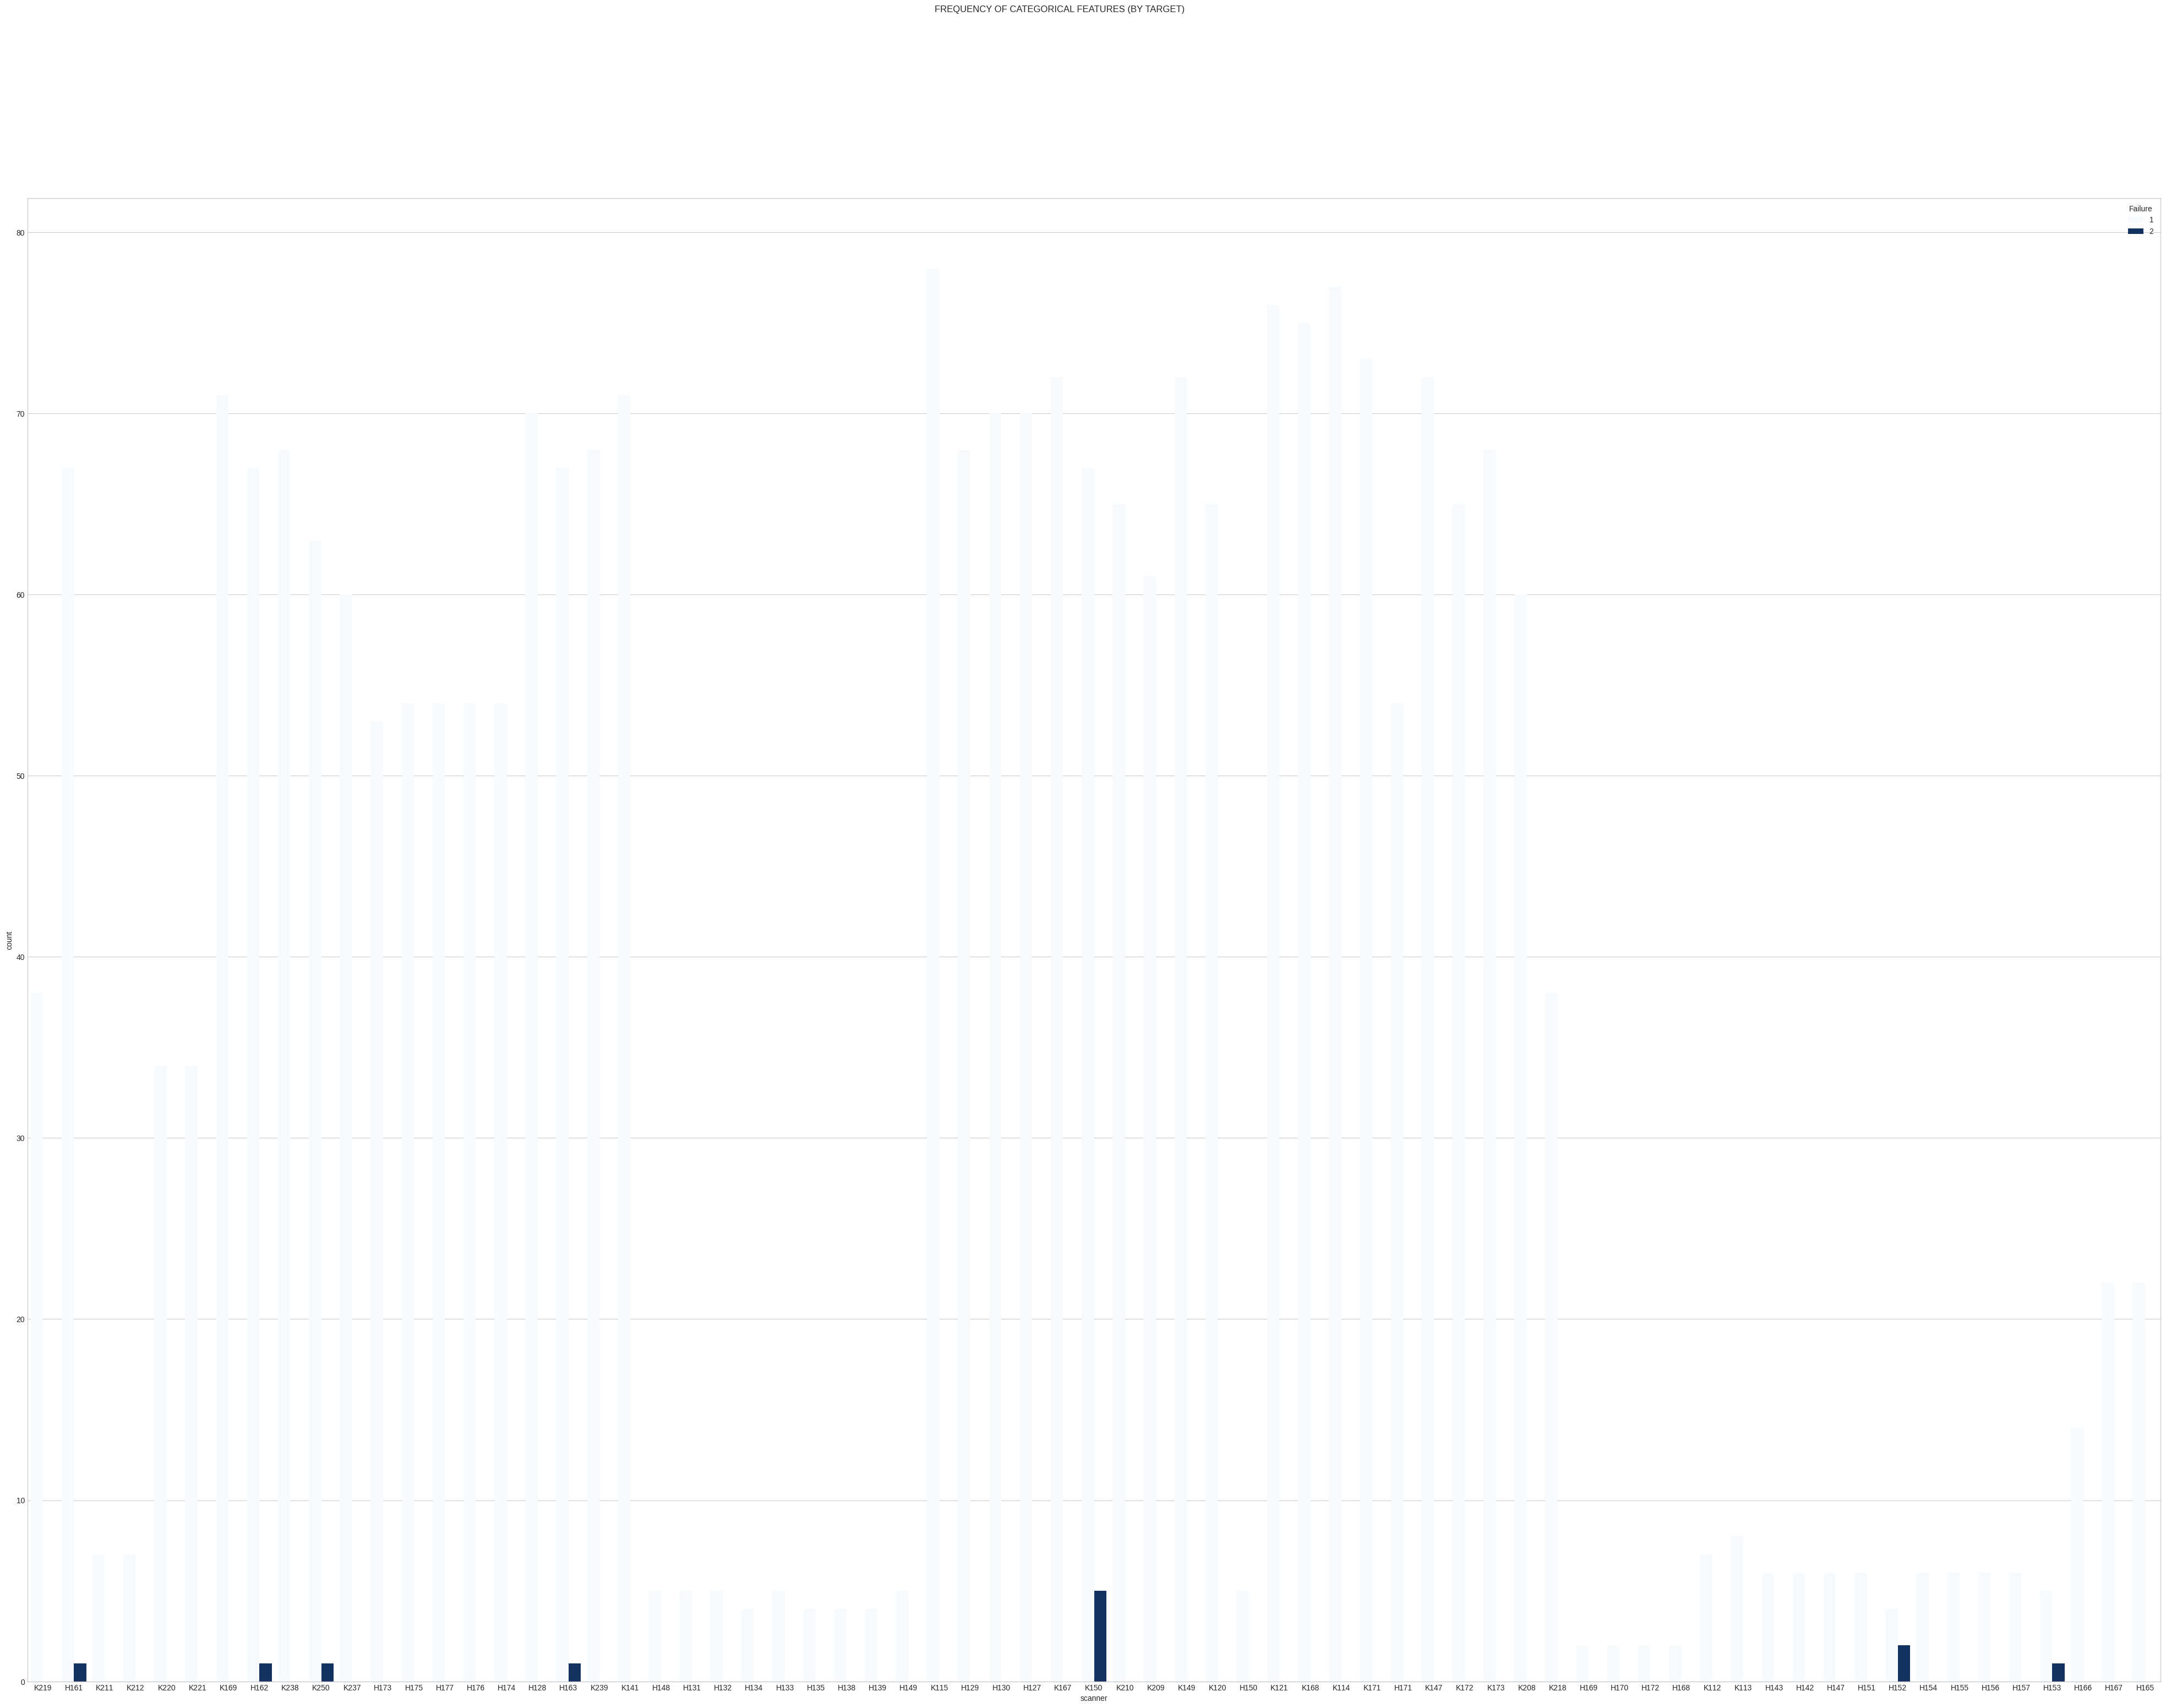

In [ ]:
# Creating a new dataframe with categorical variables


f, axes = plt.subplots(1, 1, figsize=(50, 35), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.countplot(x="scanner", hue="Failure", data=df_copy, palette="Blues")

In [ ]:
df_cp = pd.concat([df_copy, pd.get_dummies(df_copy['scanner'], prefix='scanner', dummy_na=True).astype(int)], axis=1).drop(['scanner'], axis=1)
df_cp.head()

,id,min,max,err,pixels,minf,maxf,errf,MaxMinDiff,MaxfMinfDiff,...,scanner_K212,scanner_K218,scanner_K219,scanner_K220,scanner_K221,scanner_K237,scanner_K238,scanner_K239,scanner_K250,scanner_nan
0,12,35435,35933,1.40,6,35681,35688,0.02,498,7,...,0,0,1,0,0,0,0,0,0,0
1,30,35155,36382,3.43,14,35731,35761,0.08,1227,30,...,0,0,0,0,0,0,0,0,0,0
2,47,35305,36042,2.07,43,35692,35739,0.13,737,47,...,0,0,0,0,0,0,0,0,0,0
3,48,35216,36225,2.82,61,35686,35726,0.11,1009,40,...,1,0,0,0,0,0,0,0,0,0
4,49,35196,36259,2.98,11,35709,35724,0.04,1063,15,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_cp.columns

Index(['id', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf',
       'MaxMinDiff', 'MaxfMinfDiff', 'Failure', 'scanner_H127', 'scanner_H128',
       'scanner_H129', 'scanner_H130', 'scanner_H131', 'scanner_H132',
       'scanner_H133', 'scanner_H134', 'scanner_H135', 'scanner_H138',
       'scanner_H139', 'scanner_H142', 'scanner_H143', 'scanner_H147',
       'scanner_H148', 'scanner_H149', 'scanner_H150', 'scanner_H151',
       'scanner_H152', 'scanner_H153', 'scanner_H154', 'scanner_H155',
       'scanner_H156', 'scanner_H157', 'scanner_H161', 'scanner_H162',
       'scanner_H163', 'scanner_H165', 'scanner_H166', 'scanner_H167',
       'scanner_H168', 'scanner_H169', 'scanner_H170', 'scanner_H171',
       'scanner_H172', 'scanner_H173', 'scanner_H174', 'scanner_H175',
       'scanner_H176', 'scanner_H177', 'scanner_K112', 'scanner_K113',
       'scanner_K114', 'scanner_K115', 'scanner_K120', 'scanner_K121',
       'scanner_K141', 'scanner_K147', 'scanner_K149', 'scanner_K150',


In [ ]:
df_cp = df_cp.drop('scanner_nan', axis =1)


In [ ]:
print(df_cp['min'].value_counts())

min
35186    72
35232    23
35386    15
35318    15
35313    15
         ..
34863     1
35084     1
34198     1
34484     1
34730     1
Name: count, Length: 723, dtype: int64


In [ ]:
df_cp['min'] = np.where(df_cp['min'] == -1,df_cp['min'].mean(),df_cp['min'])
df_cp['max'] = np.where(df_cp['max'] == -1,df_cp['max'].mean(),df_cp['max'])

In [ ]:
df_cp['max'].describe()

count     2603.000000
mean     36200.400307
std        554.719813
min      35761.000000
25%      36007.500000
50%      36119.000000
75%      36264.000000
max      47057.000000
Name: max, dtype: float64

In [ ]:
df_cp = df_cp.drop(['id'], axis=1)

In [ ]:
df_cp.columns.size

79

In [ ]:
# Original dataset

df_f = df_cp.drop('Failure', axis=1)
X = df_f.drop(['err','errf'],axis = 1)

columns = ['err','errf']
Y = pd.DataFrame(df_f, columns=columns)


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
gbr = GradientBoostingRegressor()
model = MultiOutputRegressor(estimator=gbr)
print(model)

MultiOutputRegressor(estimator=GradientBoostingRegressor())


In [ ]:
#cv.fit(X_train, Y_train)
model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [ ]:
score = model.score(X_train, Y_train)
print(score)

0.9999842916576225


In [ ]:
Y_pred= model.predict(X_test)

print("Y1 MSE:%.4f" % mean_squared_error(Y_test["err"], Y_pred[:,0]))
print("Y2 MSE:%.4f" % mean_squared_error(Y_test["errf"], Y_pred[:,1]))

Y1 MSE:0.0019
Y2 MSE:0.0000


In [ ]:
from sklearn.model_selection import RepeatedKFold
from numpy import absolute

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores =cross_val_score(model, X, Y, cv=cv)

In [ ]:
from numpy import absolute
from numpy import mean
from numpy import std

#summarize performance
cv_score = absolute(cv_scores)
print('Result: %.4f (%.4f)' % (mean(cv_scores), std(cv_scores)))

Result: 0.9094 (0.2698)


In [ ]:
def multi_out_regression(mod_est):
      brk_str = '=='*50
      model_rf = MultiOutputRegressor(estimator=mod_est)
      print(model_rf)
      print(brk_str)
      model_rf.fit(X_train, Y_train)


      score_rf = model_rf.score(X_train, Y_train)
      print(score_rf)
      print(brk_str)

      Y_pred= model_rf.predict(X_test)

      print("Y1 MSE:%.4f" % mean_squared_error(Y_test["err"], Y_pred[:,0]))
      print("Y2 MSE:%.4f" % mean_squared_error(Y_test["errf"], Y_pred[:,1]))

      cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
      cv_scores_rf =cross_val_score(model_rf, X, Y, cv=cv)
      print(brk_str)
      cv_scores_rf = absolute(cv_scores_rf)
      print('Result: %.4f (%.4f)' % (mean(cv_scores_rf), std(cv_scores_rf)))

In [ ]:
multi_out_regression( RandomForestRegressor())

MultiOutputRegressor(estimator=RandomForestRegressor())
0.9144678806491101
y1 MSE:0.0478
y2 MSE:0.0001
Result: 0.9052 (0.2649)


In [ ]:
from sklearn.svm import LinearSVR
multi_out_regression(LinearSVR())

MultiOutputRegressor(estimator=LinearSVR())


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.999731268894304
y1 MSE:0.0219
y2 MSE:0.0065


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: Convergen

Result: 0.4863 (0.1503)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [ ]:
from sklearn.linear_model import LinearRegression

multi_out_regression(LinearRegression() )

MultiOutputRegressor(estimator=LinearRegression())
0.9999995082448145
y1 MSE:0.0002
y2 MSE:0.0000
Result: 99016766884478091264.0000 (532776818271070126080.0000)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

multi_out_regression(KNeighborsRegressor())

MultiOutputRegressor(estimator=KNeighborsRegressor())
0.4912232803405301
y1 MSE:0.0255
y2 MSE:0.0019
Result: 0.8262 (0.2318)


In [ ]:
multi_out_regression(GradientBoostingRegressor())


MultiOutputRegressor(estimator=GradientBoostingRegressor())
0.9999842916576225
y1 MSE:0.0137
y2 MSE:0.0000
Result: 0.9101 (0.2680)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
multi_out_regression(DecisionTreeRegressor())

MultiOutputRegressor(estimator=DecisionTreeRegressor())
1.0
y1 MSE:0.0022
y2 MSE:0.0000
Result: 0.9173 (0.2464)


In [ ]:
sampleTest = df_cp.loc[(df_cp['scanner_K150'] == 1) & (df_cp['Failure'] == 2)]

In [ ]:
print(sampleTest)

          min      max    err  pixels   minf   maxf  errf  MaxMinDiff  \
1446  33509.0  37801.0  12.04      18  35708  35726  0.05        4292   
1512  33509.0  37792.0  12.01      18  35709  35725  0.04        4283   
1553  33478.0  37815.0  12.17      21  35707  35728  0.06        4337   
1766  27443.0  43960.0  46.26      34  35708  35727  0.05       16517   
1771  27443.0  43960.0  46.26      34  35708  35727  0.05       16517   

      MaxfMinfDiff  Failure  ...  scanner_K211  scanner_K212  scanner_K218  \
1446            18        2  ...             0             0             0   
1512            16        2  ...             0             0             0   
1553            21        2  ...             0             0             0   
1766            19        2  ...             0             0             0   
1771            19        2  ...             0             0             0   

      scanner_K219  scanner_K220  scanner_K221  scanner_K237  scanner_K238  \
1446          

In [ ]:
Ypred_valid = model.predict(sampleTest.drop(['err','errf','Failure'],axis = 1))

In [ ]:
print(Ypred_valid)


[[1.20245850e+01 4.97372002e-02]
 [1.19949259e+01 4.15157097e-02]
 [1.20175811e+01 5.97572867e-02]
 [4.62299591e+01 4.97372002e-02]
 [4.62299591e+01 4.97372002e-02]]


In [ ]:
res = np.where((Ypred_valid[:,0] >= 12.0) | (Ypred_valid[:,1] >=0.5),2, 1)

In [ ]:
res

array([2, 1, 2, 2, 2])

InsightS:

>The difference between Max and Min increases then the scanner will likly towards failure after the value becomes 4000 and above The difference between Maxf and Minf increases then the scanner will likly towards failure after the value becomes 100/90 and above

>Failure category: Never fail : Failure = 1 Routinely fail: Failure = 2 Expected to fail/Failing faster: Failure = 3

>Based on the model prediction value, we can drive the category mentioned above

>GradientBoostingRegressor gives good result.